<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Parse-the-Wiki-Billboard-for-1970" data-toc-modified-id="Parse-the-Wiki-Billboard-for-1970-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Parse the Wiki Billboard for 1970</a></span></li><li><span><a href="#Generalization:-billboard-from-1996-to-2019" data-toc-modified-id="Generalization:-billboard-from-1996-to-2019-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Generalization: billboard from 1996 to 2019</a></span></li><li><span><a href="#Read-the-scraped-data-into-DataFrame" data-toc-modified-id="Read-the-scraped-data-into-DataFrame-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Read the scraped data into DataFrame</a></span></li><li><span><a href="#Some-simple-queries" data-toc-modified-id="Some-simple-queries-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Some simple queries</a></span><ul class="toc-item"><li><span><a href="#The-&quot;frequent-customer&quot;" data-toc-modified-id="The-&quot;frequent-customer&quot;-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>The "frequent customer"</a></span></li></ul></li></ul></div>

**Author**: Weicheng Zhang

**Date**: Jul 2019

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
from bs4 import BeautifulSoup
import requests

### Parse the Wiki Billboard for 1970

In [3]:
# Access the webpage and ontent using requests
t1970=requests.get("http://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_1970")
# Creat a BeautifulSoul object for pasing
soup = BeautifulSoup(t1970.text, "html.parser")
# Locate the table in the HTML with a class of wikitable;
# Get the 'tr' which is esentially a row of the table containing the i
rows = soup.find("table", attrs={"class": "wikitable"}).find_all("tr")[1:]

In [4]:
rows[0]

<tr>
<td>1</td>
<td>"<a class="mw-redirect" href="/wiki/Bridge_Over_Troubled_Water_(song)" title="Bridge Over Troubled Water (song)">Bridge Over Troubled Water</a>"</td>
<td><a href="/wiki/Simon_%26_Garfunkel" title="Simon &amp; Garfunkel">Simon &amp; Garfunkel</a>
</td></tr>

In [5]:
# Extract the following data
def clean_row(r):
    ranking = int(r[0].get_text())
    song = r[1].get_text()
    singer = r[2].get_text()
    singer_url = r[2].find('a').get('href')
    return [ranking,song,singer,singer_url]

In [6]:
columns = ['ranking','song','singer','singer_url']
songs = [dict(zip(columns,clean_row(row.find_all('td')))) for row in rows]

In [7]:
songs[0]

{'ranking': 1,
 'song': '"Bridge Over Troubled Water"',
 'singer': 'Simon & Garfunkel\n',
 'singer_url': '/wiki/Simon_%26_Garfunkel'}

### Generalization: billboard from 1996 to 2019

In [8]:
import time
years = range(1996,2020)
years_billboards = {}
for year in years:
    year_billboard = requests.get("http://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_%i" % year)
    years_billboards[year] = year_billboard.text
    time.sleep(1)

In [9]:
"""
The following functions aim to get a dictionary with following data:
    ranking: ranking of the single
    song: a list of bands/singers who made this single
    song_url: url for the song(s)
    singer: a list of bands or singers on this single
    singer_url: url for the singer(s)
    
Notes
-----
1. There can be more than 1 singer for a single
2. There can be more than 1 song for a single
3. The urls for some songs/singers can be none
"""

def get_row(row):
    return row.find_all('th') + row.find_all('td')

def parse_td(row):
    return list(map(list,zip(*[(a.get("title").strip('"'), a.get("href")) for a in row.find_all("a")]))) or [[row.get_text().strip('"')], [None]]

def parse_row(row):
    return [int(row[0].get_text())] + parse_td(row[1]) + parse_td(row[2])

columns = ['ranking','song','song_url','singer','singer_url']
def parse_year(year,years_billboards):
    soup = BeautifulSoup(years_billboards[year], 'html.parser')
    rows = soup.find('table', attrs={'class':'wikitable'}).find_all('tr')[1:]
    return [dict(zip(columns,parse_row(get_row(row)))) for row in rows]

In [10]:
parse_year(2019,years_billboards)[:2]

[{'ranking': 1,
  'song': ['Old Town Road'],
  'song_url': ['/wiki/Old_Town_Road'],
  'singer': ['Lil Nas X', 'Billy Ray Cyrus'],
  'singer_url': ['/wiki/Lil_Nas_X', '/wiki/Billy_Ray_Cyrus']},
 {'ranking': 2,
  'song': ['Sunflower (Post Malone and Swae Lee song)'],
  'song_url': ['/wiki/Sunflower_(Post_Malone_and_Swae_Lee_song)'],
  'singer': ['Post Malone', 'Swae Lee'],
  'singer_url': ['/wiki/Post_Malone', '/wiki/Swae_Lee']}]

In [11]:
year_data = {year:parse_year(year,years_billboards) for year in years}

### Read the scraped data into DataFrame

In [55]:
# import json
# file_directory = open("year_data.json","w")
# json.dump(year_data,file_directory)
# file_directory.close()

# with open("year_data.json", "r") as file_directory:
#     year_data = json.load(file_directory)

In [12]:
yeardict={}
for y in year_data.keys():
    yearlist=year_data[y] # get list of singles for year
    yearlist2=[]
    for singledict in yearlist:
        singers=singledict['singer']
        for i, singer in enumerate(singers):
            songs=singledict['song'] # generally one per single but maybe more
            for j, song in enumerate(songs): # now inside each singer song combination
                nd={}
                nd['singer'] = singer
                nd['singer_url'] = singledict['singer_url'][i]
                nd['song'] = song
                nd['song_url'] = singledict['song_url'][j]
                nd['ranking'] = singledict['ranking']
                yearlist2.append(nd)
    yeardict[y]=pd.DataFrame(yearlist2) 

In [13]:
yearspanel=pd.Panel.from_dict(yeardict, orient="minor") # stack dataframes into a panel
hierframe=yearspanel.to_frame().reset_index().drop('major',axis=1) # flattening leads to a hierarchical index
df = hierframe.rename(columns = {'minor':'year'})
df.year = df.year.astype('int')
df.ranking = df.ranking.astype('int')

/Users/weichengzhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  """Entry point for launching an IPython kernel.


In [14]:
df.head()

,year,ranking,singer,singer_url,song,song_url
0,1996,1,Los del Río,/wiki/Los_del_R%C3%ADo,Macarena (song),/wiki/Macarena_(song)
1,1997,1,Elton John,/wiki/Elton_John,Something About the Way You Look Tonight,/wiki/Something_About_the_Way_You_Look_Tonight
2,1998,1,Next (group),/wiki/Next_(group),Too Close (Next song),/wiki/Too_Close_(Next_song)
3,1999,1,Cher,/wiki/Cher,Believe (Cher song),/wiki/Believe_(Cher_song)
4,2000,1,Faith Hill,/wiki/Faith_Hill,Breathe (Faith Hill song),/wiki/Breathe_(Faith_Hill_song)


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3309 entries, 0 to 3308
Data columns (total 6 columns):
year          3309 non-null int64
ranking       3309 non-null int64
singer        3309 non-null object
singer_url    3309 non-null object
song          3309 non-null object
song_url      3309 non-null object
dtypes: int64(2), object(4)
memory usage: 155.2+ KB


### Some simple queries

#### The "frequent customer"
Frequent customer = # times a singer appears in the billboard

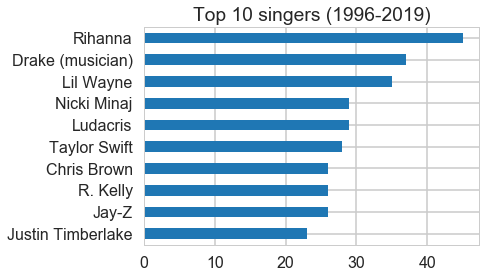

In [16]:
quality_singer_distribution = df.singer.value_counts()
quality_singer_distribution[:10][::-1].plot(kind='barh', title='Top 10 singers (1996-2019)')